# Certificates

This notebook demonstrates the evaluation of our invariance-aware certificates,  
on point cloud classification data, which we use in Figs. 5, 6, 12, 13, 14, 15, 16.

We first consider adversarial scaling and then have a look at random perturbations and rotations.

In [8]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torchvision.datasets import MNIST

First, we need to download the MNIST dataset:

In [9]:
from pointcloud_invariance_smoothing.data import get_dataset

MNIST('./data', train=True, download=True)
MNIST('./data', train=False, download=True)

data_train, data_val, data_test = get_dataset('mnist', './data')

We also load the results of applying our EnsPointNet classifier to randomly perturbed
MNIST pointclouds with smoothing standard deviation $\sigma = 0.15$.

The results file holds two arrays of shape n_pointclouds $\times$ n_classes indicating
how many times each point cloud was classified as which class.  
The first one is used for making a smoothed prediction, the second one is used for certifying it.

In [10]:
mc_sample_results = torch.load('./data/mnist_0-15_samples')
print(mc_sample_results.keys())

dict_keys(['datapoint_idx', 'targets', 'votes_pred', 'accuracy', 'votes_cert'])


## Adversarial scaling

The first setting we considered when evaluating the certificates was adversarial scaling of MNIST,  
i.e. the clean input $X$ being multiplied by a scalar $c$ such that $||c \cdot X - X|| = ||\Delta||$
for some fixed $||\Delta||$.


### Example
In the following example, we take a digit $X$ from MNIST (represented as a 2D point cloud) and scale it such that $||c \cdot X - X|| = 4$.

In [11]:
from pointcloud_invariance_smoothing.evaluation.eval_forward_certs import generate_parallel_perturbation

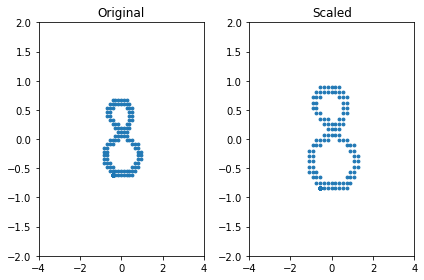

In [12]:
mnist_eight = np.load('./data/mnist_eight.npy')

plt.subplot(121)
plt.scatter(mnist_eight[:, 1], mnist_eight[:, 0], s=8)
plt.xlim(-4, 4)
plt.ylim(-2, 2)
plt.title('Original')

scaled_mnist_eight = generate_parallel_perturbation(mnist_eight, norm_delta=4)

plt.subplot(122)
plt.scatter(scaled_mnist_eight[:, 1], scaled_mnist_eight[:, 0], s=8)
plt.xlim(-4, 4)
plt.ylim(-2, 2)
plt.title('Scaled')

plt.tight_layout()

In [13]:
delta = np.linalg.norm(scaled_mnist_eight - mnist_eight)
print(f'The difference between the scaled and original point cloud has norm {delta}.')

The difference between the scaled and original point cloud has norm 4.0.


### Experiment
We repeat the experiment from Fig. 6, in which we compare the ability of the orbit-based  
and the provably tight certificate for rotation invariance to certify robustness to such scaling attacks  
with different norms.

To reduce the runtime and keep the code simple for this demo, we make the following adjustments:  
* evaluate on a coarser grid of perturbation norms
* only consider invariance under SO(2)
* only evaluate probabilistic lower bound on the tight certificate
* only evaluate on 50 point clouds

In [14]:
# This is just a nice wrapper for our certificates
# which determines the majority vote, lower bounds the clean prediction probability
# and then evaluates one of the certificates
from cert_helpers import certified_correct_scaling  

In [15]:
sigma = 0.15
n_pointclouds = 50

In [16]:
certified_accs_tight = []  # certified accuracies for our model
certified_accs_orbit = []  # certified accuracies for orbit-based certificate

votes_pred = mc_sample_results['votes_pred']
votes_cert = mc_sample_results['votes_cert']

norms_delta = np.linspace(0, 0.5, 10)  # Perturbation norms to evaluate on

for norm_delta in tqdm(norms_delta):  # iterate over perturbation norms

    certified_accs_tight.append(0)
    certified_accs_orbit.append(0)

    for i, idx in enumerate(mc_sample_results['datapoint_idx'][:n_pointclouds]):  # iterate over dataset
        x, target = data_test[idx]
        assert target == mc_sample_results['targets'][i]

        if certified_correct_scaling(x, target, votes_pred[i], votes_cert[i], norm_delta, sigma, method='tight'):
            certified_accs_tight[-1] += 1 / n_pointclouds

        if certified_correct_scaling(x, target, votes_pred[i], votes_cert[i], norm_delta, sigma, method='orbit'):
            certified_accs_orbit[-1] += 1 / n_pointclouds

100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


(0.0, 1.0)

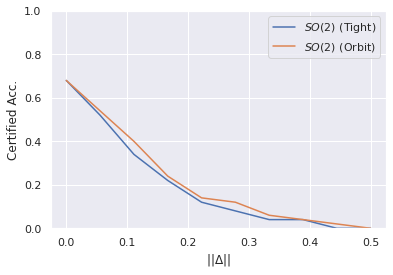

In [17]:
sns.set_theme()
pal = sns.color_palette('colorblind', 2)

plt.plot(norms_delta, certified_accs_tight, label='$SO(2)$ (Tight)')
plt.plot(norms_delta, certified_accs_orbit, label='$SO(2)$ (Orbit)')
plt.legend()

plt.xlabel('$||\Delta||$')
plt.ylabel('Certified Acc.')
plt.ylim(0, 1)

We see that both both certificates yield very similar results.  
The tight certificate has marginally lower certified accuracy, because
it has to be approximated using Monte Carlo sampling .

## Random rotational components
Finally, we evaluate the ability of the tight and orbit-based certificate to account for adversarial rotations by randomly generating perturbed samples in two steps:  
1. ) Randomly perturbing the data with Gaussian noise scaled to norm $||\Delta||$.  
2. ) Rotating by an angle $\theta$.

### Example
In the following example, we take a digit from MNIST (represented as a 2D point cloud),  
perturb it with $||\Delta||=1$ and then rotate it by $20$°.

In [18]:
from pointcloud_invariance_smoothing.evaluation.eval_forward_certs import (
    generate_random_perturbation,
    generate_random_rotation_matrix)

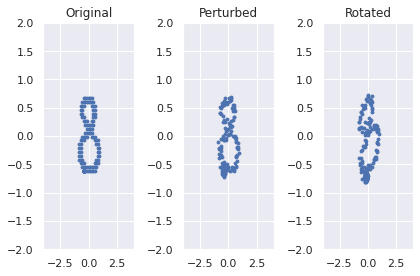

In [19]:
mnist_eight = np.load('./data/mnist_eight.npy')

plt.subplot(131)
plt.scatter(mnist_eight[:, 1], mnist_eight[:, 0], s=8)
plt.xlim(-4, 4)
plt.ylim(-2, 2)
plt.title('Original')

perturbed_mnist_eight = generate_random_perturbation(mnist_eight, 1.0, 0, False)

plt.subplot(132)
plt.scatter(perturbed_mnist_eight[:, 1], perturbed_mnist_eight[:, 0], s=8)
plt.xlim(-4, 4)
plt.ylim(-2, 2)
plt.title('Perturbed')

R = generate_random_rotation_matrix(perturbed_mnist_eight, 20, False)
perturbed_mnist_eight = perturbed_mnist_eight @ R.T

plt.subplot(133)
plt.scatter(perturbed_mnist_eight[:, 1], perturbed_mnist_eight[:, 0], s=8)
plt.xlim(-4, 4)
plt.ylim(-2, 2)
plt.title('Rotated')

plt.tight_layout()

### Experiment
We repeat the experiment from Fig. 13e, in which we compare the ability of the  
black-box, orbit-based and tight certificate to certify robustness to such attacks with  
different rotation angles.

To reduce the runtime and keep the code simple for this demo, we make the following adjustments:  
* evaluate on a coarser grid of angles
* only evaluate probabilistic lower bound on the tight certificate
* only evaluate on 50 point clouds
* only perturb each point cloud once

In [20]:
sigma = 0.1
n_pointclouds = 50
norm_delta = 0.1

In [21]:
mc_sample_results = torch.load('./data/mnist_0-1_samples')

In [22]:
# This is just a nice wrapper for our certificates
# which determines the majority vote, lower bounds the clean prediction probability
# and then evaluates one of the certificates
from cert_helpers import certified_correct

In [23]:
certified_accs_tight = []  # certified accuracies for our model
certified_accs_orbit = []  # certified accuracies for orbit-based certificate
certified_accs_blackbox = []  # certified accuracies for black-box certificate


votes_pred = mc_sample_results['votes_pred']
votes_cert = mc_sample_results['votes_cert']

angles = np.linspace(0, 5, 10)

for angle in tqdm(angles):  # iterate over angles

    certified_accs_tight.append(0)
    certified_accs_orbit.append(0)
    certified_accs_blackbox.append(0)

    for i, idx in enumerate(mc_sample_results['datapoint_idx'][:n_pointclouds]):  # iterate over dataset
        x, target = data_test[idx]
        assert target == mc_sample_results['targets'][i]
        x = x.numpy()

        x_pert = generate_random_perturbation(x, norm_delta, angle, False)

        if certified_correct(x, x_pert, target, votes_pred[i], votes_cert[i], norm_delta, sigma, method='tight'):
            certified_accs_tight[-1] += 1 / n_pointclouds

        if certified_correct(x, x_pert, target, votes_pred[i], votes_cert[i], norm_delta, sigma, method='orbit'):
            certified_accs_orbit[-1] += 1 / n_pointclouds

        if certified_correct(x, x_pert, target, votes_pred[i], votes_cert[i], norm_delta, sigma, method='black-box'):
            certified_accs_blackbox[-1] += 1 / n_pointclouds

100%|██████████| 10/10 [00:34<00:00,  3.46s/it]


(0.0, 1.0)

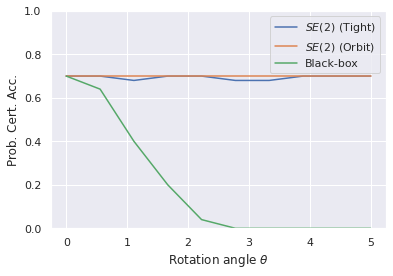

In [25]:
sns.set_theme()
pal = sns.color_palette('colorblind', 3)

plt.plot(angles, certified_accs_tight, label='$SE(2)$ (Tight)')
plt.plot(angles, certified_accs_orbit, label='$SE(2)$ (Orbit)')
plt.plot(angles, certified_accs_blackbox, label='Black-box')
plt.legend()

plt.xlabel('Rotation angle $\\theta$')
plt.ylabel('Prob. Cert. Acc.')
plt.ylim(0, 1)

We see that the invariance-aware certificates yield very similar results, 
whereas the black-box certificate fails even for small rotation angles.